<a href="https://colab.research.google.com/github/AustinAlgebra/data_science/blob/master/volcanoes_on_venus_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import itertools
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [2]:
!kaggle datasets download -d fmena14/volcanoesvenus

 98% 226M/231M [00:02<00:00, 94.7MB/s]
100% 231M/231M [00:02<00:00, 104MB/s] 


In [3]:
!unzip volcanoesvenus.zip

Archive:  volcanoesvenus.zip
  inflating: Volcanoes_test/test_images.csv  
  inflating: Volcanoes_test/test_labels.csv  
  inflating: Volcanoes_train/train_images.csv  
  inflating: Volcanoes_train/train_labels.csv  
  inflating: volcanoes_test/test_images.csv  
  inflating: volcanoes_test/test_labels.csv  
  inflating: volcanoes_train/train_images.csv  
  inflating: volcanoes_train/train_labels.csv  


In [4]:
test_img_df = pd.read_csv('Volcanoes_test/test_images.csv')
test_label_df = pd.read_csv('Volcanoes_test/test_labels.csv')
train_img_df = pd.read_csv('Volcanoes_train/train_images.csv')
train_label_df = pd.read_csv('Volcanoes_train/train_labels.csv')

In [5]:
def XFix(X):
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # adding column names as a new row
    X.index = X.index + 1  # shifting index
    X.sort_index(inplace=True)  # sorting the index

# Creating copy DataFrames and applying the Fix code to it
train_img_fix = train_img_df.copy()
XFix(train_img_fix)
test_img_fix = test_img_df.copy()
XFix(test_img_fix)
train_img_fix.columns = np.arange(len(train_img_fix.columns))
test_img_fix.columns = np.arange(len(test_img_fix.columns))

In [6]:
# Creating DataFrames for running models.

X_train = train_img_fix
y_train = np.array(train_label_df['Volcano?'].tolist())
X_test = test_img_fix
y_test = np.array(test_label_df['Volcano?'].tolist())

In [7]:
# Running an initial Random Forest model just to get a starting point.
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [8]:
rfc = RandomForestClassifier()
cross_val_score(rfc, X_train, y_train, cv=3)

array([0.91902314, 0.90827261, 0.91555937])

In [9]:
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predict_test = rfc.predict(X_test)
accuracy_score(y_test, predict_test)

0.9038039502560351

In [10]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


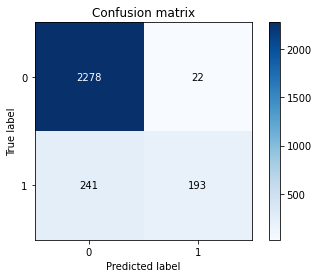

In [11]:
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [12]:
# Creating a function for accuracy, recall, and precision scores.
# I can use this for future models to evaluate the confusion matrix.

tp = 188
tn = 2285
fp = 15
fn = 246

def acc_rec_prec(tp,tn,fp,fn):
  accuracy = round(((tp+tn)/(tp+tn+fp+fn))*100,2)
  recall = round((tp/(tp+fn))*100, 2)
  precision = round((tp/(tp+fp))*100, 2)
  print(f'accuracy: {accuracy}%')
  print(f'recall: {recall}%')
  print(f'precision: {precision}%')

acc_rec_prec(tp,tn,fp,fn)

accuracy: 90.45%
recall: 43.32%
precision: 92.61%


In [13]:
# After running with PCA and without, the model performs much better without PCA.
# I could reproduce pretty high accuracy rates, but the confusion matrix showed
# very low recall and precision.
# I wonder if fixing the imbalance in classes could help improve the model.

print(np.count_nonzero(y_train == 1))
print(np.count_nonzero(y_train == 0))

1000
6000


In [14]:
rfc = RandomForestClassifier(class_weight='balanced')
cross_val_score(rfc, X_train, y_train, cv=3)

array([0.89888603, 0.89712816, 0.89669953])

Accuracy score: 0.8902706656912948
Confusion matrix, without normalization


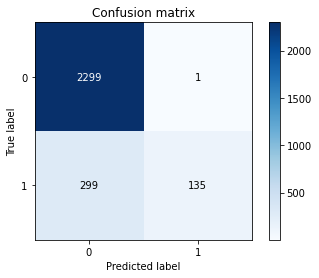

In [19]:
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)
predict_test = rfc.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predict_test)}')
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [20]:
tp = 135
tn = 2299
fp = 1
fn = 299

acc_rec_prec(tp,tn,fp,fn)

accuracy: 89.03%
recall: 31.11%
precision: 99.26%


Accuracy score: 0.8858814923189466
Confusion matrix, without normalization


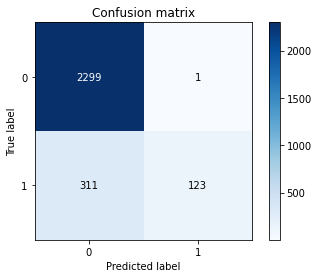

In [21]:
rfc = RandomForestClassifier(class_weight='balanced_subsample')
rfc.fit(X_train, y_train)
predict_test = rfc.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predict_test)}')
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [22]:
tp = 123
tn = 2299
fp = 1
fn = 311

acc_rec_prec(tp,tn,fp,fn)

accuracy: 88.59%
recall: 28.34%
precision: 99.19%


In [31]:
y_train_df = pd.DataFrame(y_train)
y_train_df.rename(columns={0: 'Volcano'}, inplace=True)
train_data = pd.concat([X_train, y_train_df], axis=1)
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
0,95,101,99,103,95,86,96,89,70,104,115,96,89,102,109,108,102,104,95,91,100,99,97,100,107,109,98,98,94,98,102,87,82,94,105,93,102,107,98,105,...,95,105,103,74,88,106,111,90,96,101,90,97,102,97,106,108,107,93,74,106,115,107,102,91,103,111,105,116,117,111,107,92,89,103,99,117,116,118,96,1
1,91,92,91,89,92,93,96,101,107,104,92,81,76,83,88,93,91,92,93,90,83,81,79,84,86,87,92,93,94,94,87,83,95,96,94,91,93,96,93,87,...,91,91,89,88,90,88,93,95,106,113,116,108,94,92,96,99,92,87,89,105,119,121,116,111,113,112,103,101,103,103,92,93,95,98,105,104,100,90,81,0
2,87,70,72,74,84,78,93,104,106,106,94,79,96,88,86,89,98,94,76,78,91,96,86,71,82,76,72,81,90,84,81,70,75,91,81,81,92,94,79,97,...,80,83,93,94,91,90,94,96,78,88,95,121,108,88,87,89,100,99,88,107,108,101,88,95,81,57,84,89,92,84,71,95,102,94,80,91,80,84,90,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,114,104,103,81,94,108,96,79,113,113,114,112,107,110,112,98,76,84,97,99,95,68,97,91,97,96,83,100,106,94,81,89,84,80,90,92,80,88,96,0
4,114,118,124,119,95,118,105,116,123,112,110,113,119,112,105,121,117,125,136,141,120,120,129,135,132,124,109,126,113,110,106,107,113,116,123,101,99,89,81,101,...,116,114,103,114,109,113,126,110,84,92,111,114,125,122,109,113,111,121,119,103,114,118,118,108,111,109,100,101,105,116,113,102,93,109,104,106,117,111,115,0


Random under-sampling:
1    1000
0    1000
Name: Volcano, dtype: int64


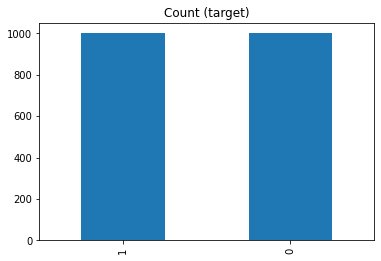

In [45]:
# Class count
target_0_count, target_1_count=train_data.iloc[:,-1].value_counts()
# Seperate classes
target_0 = train_data[train_data.iloc[:,-1] == 0]
target_1 = train_data[train_data.iloc[:,-1] == 1]
# Resample target1 to match target 0 count
target_0_undersample = target_0.sample(target_1_count)
# Merge back to single df
train_undersample = pd.concat([target_0_undersample, target_1], 
                             axis=0)
# Show counts and plot
print('Random under-sampling:')
print(train_undersample.iloc[:,-1].value_counts())
train_undersample.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');

In [44]:
target_0_undersample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
27,109,103,105,103,106,97,108,104,119,118,115,129,127,102,105,112,130,145,144,134,125,105,116,110,109,116,78,100,117,110,74,65,81,110,111,95,99,105,89,96,...,111,101,109,108,89,101,87,99,94,84,104,105,71,74,82,89,95,103,104,102,99,108,119,111,115,104,99,104,78,105,86,98,87,74,95,89,94,98,89,0
4939,129,139,126,135,134,133,129,126,135,127,124,129,132,119,124,129,121,108,133,129,124,134,127,120,124,127,129,129,131,136,131,124,133,128,116,141,134,122,127,125,...,121,130,132,120,123,120,120,124,126,136,145,146,128,114,124,120,129,124,122,130,124,117,125,123,100,140,147,131,114,122,130,128,113,123,136,131,126,129,143,0
2206,84,84,91,104,88,103,116,113,104,107,108,103,113,127,125,114,116,113,143,154,141,114,116,115,96,93,106,108,103,100,93,100,106,93,77,70,84,101,99,94,...,90,90,93,90,104,105,72,84,93,112,101,103,105,90,101,87,89,91,98,91,89,90,83,97,106,96,93,92,80,91,86,90,83,75,95,96,102,104,82,0
1954,103,116,131,116,86,79,75,105,110,107,112,113,89,97,98,91,84,118,121,88,80,93,103,93,83,116,119,103,77,88,84,95,88,81,83,95,111,107,91,91,...,126,137,125,109,92,90,82,77,77,77,75,61,67,91,77,79,89,86,74,96,96,99,96,74,82,96,96,89,83,91,95,90,72,74,87,83,87,92,84,0
968,89,99,97,82,76,92,90,92,76,79,79,65,95,93,86,102,102,91,84,89,92,73,73,87,80,90,83,94,78,86,79,80,69,96,102,84,67,77,86,89,...,70,89,89,90,84,73,77,100,118,110,96,80,69,83,87,87,89,89,94,90,116,119,96,93,93,76,58,77,89,92,88,79,84,91,95,93,74,89,86,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,103,101,76,97,97,93,109,120,122,108,88,91,77,79,77,89,72,89,99,89,92,96,86,62,83,95,92,104,119,129,115,101,110,106,110,106,122,122,109,116,...,117,106,106,124,118,101,92,96,98,80,91,103,111,99,110,106,111,122,109,109,111,100,103,108,103,84,94,116,115,110,113,106,102,101,97,108,109,94,92,0
5889,90,89,93,88,79,81,73,90,105,90,92,101,102,91,122,120,107,106,86,78,107,100,103,81,96,101,89,107,142,132,99,105,122,106,111,98,112,102,107,113,...,101,117,112,107,96,106,81,117,83,98,92,92,104,104,120,117,115,90,126,125,103,122,105,104,84,104,133,100,87,84,115,129,112,109,104,113,131,146,148,0
6232,126,110,115,111,121,130,125,135,137,132,122,122,104,115,123,121,115,109,110,124,131,139,145,131,123,129,135,138,132,109,132,145,138,134,128,120,135,140,139,129,...,133,130,122,116,130,142,141,140,132,112,118,121,129,131,125,127,131,128,116,126,130,132,133,143,137,112,112,122,136,144,143,137,140,141,135,126,129,124,137,0
419,99,104,110,103,96,111,120,98,106,115,117,103,92,105,112,125,133,134,132,128,132,144,129,107,110,106,94,100,108,134,151,144,127,123,124,114,112,136,139,124,...,112,123,130,118,105,117,115,137,154,155,142,115,109,117,117,109,106,93,83,94,114,110,88,109,111,105,99,84,98,106,108,107,88,115,120,112,87,87,98,0


In [47]:
X_train = train_undersample.iloc[:,:-1]
y_train = train_undersample.iloc[:,-1]
print(X_train.shape)
print(y_train.shape)

(2000, 12100)
(2000,)


In [48]:
rfc = RandomForestClassifier()
cross_val_score(rfc, X_train, y_train, cv=3)

array([0.85007496, 0.85457271, 0.86336336])

Accuracy score: 0.8910021945866862
Confusion matrix, without normalization


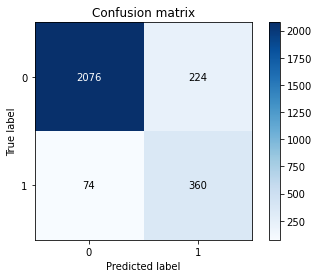

In [49]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predict_test = rfc.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predict_test)}')
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [50]:
tp = 360
tn = 2076
fp = 224
fn = 74

acc_rec_prec(tp,tn,fp,fn)

accuracy: 89.1%
recall: 82.95%
precision: 61.64%


In [51]:
y_test_df = pd.DataFrame(y_test)
y_test_df.rename(columns={0: 'Volcano'}, inplace=True)
test_data = pd.concat([X_test, y_test_df], axis=1)
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12061,12062,12063,12064,12065,12066,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076,12077,12078,12079,12080,12081,12082,12083,12084,12085,12086,12087,12088,12089,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099,Volcano
0,107,116,108,101,107,109,108,110,100,109,118,115,111,121,114,94,98,100,99,108,112,107,100,88,98,104,107,105,96,94,83,94,97,95,90,96,100,110,109,99,...,93,91,98,108,100,105,106,104,108,100,94,100,104,104,108,115,116,96,99,109,114,117,118,121,118,110,103,113,116,111,110,109,109,101,106,106,117,130,134,0
1,93,95,98,100,90,100,108,98,90,103,107,93,90,91,104,113,104,102,113,108,100,105,97,102,115,110,110,104,93,108,104,92,87,107,113,94,73,81,83,88,...,88,83,95,106,102,95,96,105,109,111,119,110,93,84,89,97,121,118,101,96,95,109,130,121,89,89,100,116,109,86,93,59,88,89,89,92,99,92,113,0
2,108,108,92,116,116,140,126,104,112,103,107,107,100,116,107,118,117,121,110,95,106,120,112,106,104,90,118,117,118,132,130,118,109,113,107,141,149,139,130,148,...,136,133,116,125,111,113,112,98,104,106,80,132,127,122,112,108,109,118,113,113,107,117,130,112,115,120,120,122,118,118,111,113,107,107,121,141,160,131,138,1
3,165,164,156,159,151,120,103,114,114,116,95,87,81,65,70,69,69,71,81,75,72,88,87,103,97,77,55,81,91,99,87,72,69,87,88,90,104,87,77,100,...,80,82,90,78,75,71,74,91,86,99,95,98,89,69,64,81,89,87,84,86,90,96,106,100,80,78,83,93,90,69,96,109,91,94,83,48,69,86,75,0
4,105,106,84,115,121,103,94,108,103,91,95,102,90,96,105,92,86,99,102,108,119,118,114,97,94,110,89,74,92,80,83,92,103,100,99,97,89,92,102,101,...,91,100,98,98,108,107,88,76,81,77,87,81,90,87,70,77,100,104,96,84,96,96,96,89,90,102,98,87,72,92,89,96,89,91,102,99,90,90,73,1


Random under-sampling:
1    434
0    434
Name: Volcano, dtype: int64


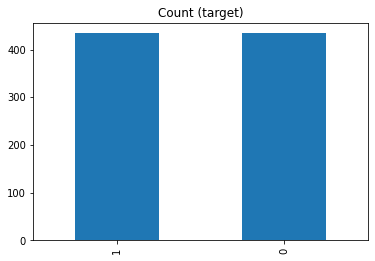

In [52]:
# Class count
target_0_count, target_1_count=test_data.iloc[:,-1].value_counts()
# Seperate classes
target_0 = test_data[test_data.iloc[:,-1] == 0]
target_1 = test_data[test_data.iloc[:,-1] == 1]
# Resample target1 to match target 0 count
target_0_undersample = target_0.sample(target_1_count)
# Merge back to single df
test_undersample = pd.concat([target_0_undersample, target_1], 
                             axis=0)
# Show counts and plot
print('Random under-sampling:')
print(test_undersample.iloc[:,-1].value_counts())
test_undersample.iloc[:,-1].value_counts().plot(kind='bar', title='Count (target)');

Accuracy score: 0.8663594470046083
Confusion matrix, without normalization


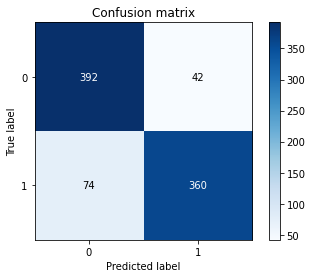

In [53]:
X_test = test_undersample.iloc[:,:-1]
y_test = test_undersample.iloc[:,-1]
predict_test = rfc.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predict_test)}')
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [54]:
tp = 360
tn = 392
fp = 42
fn = 74

acc_rec_prec(tp,tn,fp,fn)

accuracy: 86.64%
recall: 82.95%
precision: 89.55%


In [56]:
from sklearn.model_selection import validation_curve

n_estimators = [int(x) for x in np.linspace(start = 100, 
                                            stop = 1000, 
                                            num = 5)]

train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators, cv = 3)

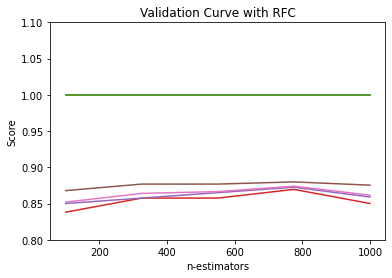

In [58]:
train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.title("Validation Curve with RFC")
plt.xlabel("n-estimators")
plt.ylabel("Score")
plt.ylim(0.8, 1.1)
lw = 2
plt.plot(n_estimators,train_scoreNum)
plt.plot(n_estimators, test_scoreNum)
plt.plot(n_estimators, test_scores_mean)
plt.show()

In [64]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, 
                                            stop = 1000, 
                                            num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start=10,stop=110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, 
                                param_distributions = random_grid, 
                                n_iter = 5, 
                                cv = 3, 
                                verbose=2, 
                                random_state=42, 
                                n_jobs = -1)
# Fit the random search model
rfc_random.fit(train_img_fix, train_label_df['Volcano?'])


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 26.4min finished


NameError: ignored

In [65]:
rfc_random.best_params_

{'bootstrap': False,
 'max_depth': 85,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

{'bootstrap': False,
 'max_depth': 85,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

Accuracy score: 0.8778801843317973
Confusion matrix, without normalization


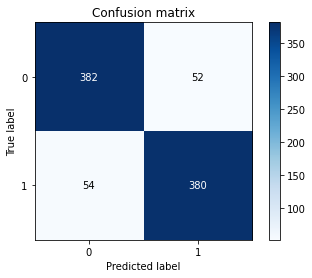

In [66]:
best_params = rfc_random.best_params_
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)
predict_test = rfc.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predict_test)}')
cm = confusion_matrix(y_test, predict_test)
plot_confusion_matrix(cm,[0,1],False)

In [67]:
tp = 380
tn = 382
fp = 52
fn = 54

acc_rec_prec(tp,tn,fp,fn)

accuracy: 87.79%
recall: 87.56%
precision: 87.96%
